In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from EnvLibs import Environment, RewardKernel, TrafficGenerator

In [6]:
class PolicyDemoAdaptiveAlpha:
    def __init__(self, params):
        self.params = params
        self.rewardKernel = RewardKernel(params)
        self.M = 3
        self.alphaList = params['alphaList']
    
    def getActionFromObervation(self, u):
        w = self.typeAllocator(u, self.params['LEN_window'])
        JmdpRecord = []
        for alpha in self.alphaList:
            r = np.floor(alpha*self.params['B'])/(np.sum(w)+1e-10) * w 
            Jmdp = self.rewardKernel.getReward(u, w, r, self.M, alpha)
            JmdpRecord.append(Jmdp)
        alpha = self.alphaList[np.argmin(JmdpRecord)]
        r = self.getDependentAction(u, w, alpha, self.params['B'])
        return w, r, self.M, alpha
    
    def typeAllocator(self, u, lEN_window):
        w = (u>int(lEN_window*0.5)).astype(int)
        return w
    
    def getDependentAction(self, u, w, alpha, B):
        r = np.floor(alpha*B)/(np.sum(w)+1e-10) * w
        return r

In [7]:
class Simulator:
    def __init__(self, params, trafficGenerator):
        self.params = params
        self.trafficGenerator = trafficGenerator
    
    def runSimulation(self, policy, num_epochs=1000, mode="test", type="data"):
        """
        Run simulation with a given policy function
        
        Args:
            policy_func: Function that takes (u, params) and returns (w, r, M, alpha) as action
            params: Dictionary of parameters
            num_epochs: Number of simulation epochs (default: 1000)
        
        Returns:
            rewardRecord: List of rewards for each epoch
        """
        env = Environment(self.params, self.trafficGenerator)
        env.selectMode(mode=mode, type=type)
        rewardRecord = []   
        alphaRecord = []
        for epoch in range(num_epochs):
            u = env.updateStates()
            (w, r, M, alpha) = policy.getActionFromObervation(u)
            reward = env.applyActions(np.array(w), np.array(r), M, alpha)
            rewardRecord.append(reward)
            alphaRecord.append(alpha)

        return rewardRecord, alphaRecord, env

MDP Parameters:
N_user: 4
LEN_window: 10
r_bar: 4
B: 40
M_list: [2, 3]
randomSeed: 999
alphaList: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
N_aggregation: 4
avgPacketLossRate_mdp: 0.005431643376131164, avgPacketLossRate_adaptive: 0.024403688113850446


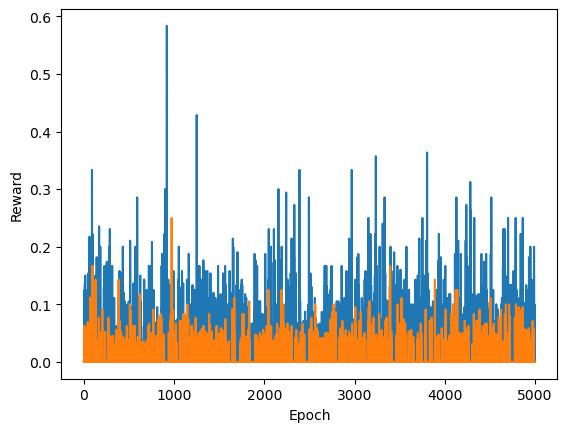

In [8]:
dataFlow = "thumb_bk"

with open(f'Results/MdpPolicy/mdpKernel_{dataFlow}.pkl', 'rb') as f:
    mdpPolicy = pickle.load(f)
with open(f'Results/MdpPolicy/params_{dataFlow}.pkl', 'rb') as f:
    params = pickle.load(f)
with open(f'Results/MdpPolicy/trafficGenerator_{dataFlow}.pkl', 'rb') as f:
    trafficGenerator = pickle.load(f)

alphaAdaptivePolicy = PolicyDemoAdaptiveAlpha(params)

print("MDP Parameters:")
for key, value in params.items():
    print(f"{key}: {value}")

simulator = Simulator(params, trafficGenerator)
rewardRecord_mdp, alphaRecord_mdp, env_mdp = simulator.runSimulation(mdpPolicy, num_epochs=5000, mode="test", type="data")
rewardRecord_adaptive, alphaRecord_adaptive, env_adaptive = simulator.runSimulation(alphaAdaptivePolicy, num_epochs=5000, mode="test", type="data")
avgPacketLossRate_mdp = env_mdp.getPacketLossRate()
avgPacketLossRate_adaptive = env_adaptive.getPacketLossRate()
print(f"avgPacketLossRate_mdp: {avgPacketLossRate_mdp}, avgPacketLossRate_adaptive: {avgPacketLossRate_adaptive}")

plt.plot(rewardRecord_adaptive)
plt.plot(rewardRecord_mdp)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.show()